In [1]:
using LinearAlgebra
using Plots
using Dierckx
using Optim
using LaTeXStrings

In [2]:
include("Models.jl")
include("Utils.jl")
include("BellmanEq.jl")

BellmanEq (generic function with 1 method)

In [3]:
m = Models()

Models{Int64,Float64,Array{Float64,1}}(0.96, 1.0, 0.4, 1.0, 10, 11, [0.05, 0.145, 0.24, 0.335, 0.43, 0.525, 0.62, 0.715, 0.81, 0.905, 1.0], 1000, 1.0e-5)

In [4]:
function Robinson_crusoe(m)
    """
    最適化(optimization)と内挿法(interpolation)をつかって
    ロビンソン・クルーソー経済を解く.
    
    # Arguments
    -`m::Models`: パラメータを含む構造体
    
    # Returns 
    -`vfcn::Matrix{Float64,2}`: 価値関数
    -`pfcn::Matrix{Float64,2}`: 政策関数
    -`cfcn::Matrix{Float64,2}`: 消費関数
    """
    
    #= 変数を定義 =#
    pfcn = zeros(m.nk, m.TT) # 政策関数
    vfcn = similar(pfcn) # 価値関数
    cfcn = similar(pfcn) # 消費関数
    wealth = m.kgrid.^m.α # 利用可能な資産
    
    #= 最終期(全てを消費) =#
    # pfcn[:,end] .= 0.0 # 全て消費するので貯蓄はゼロ
    cfcn[:, end] = wealth
    vfcn[:,end] = Utils.CRRA.(cfcn[:,end], m.γ) # 消費から得られる効用
    
    # メインループ
    @inbounds for t in m.TT-1 : -1 : 1 # 滞在期間について後ろから解いていく
        
        #次期の価値関数を補間
        #vnext = Spline1D(m.kgrid, vfcn[:,t+1], k = 1, bc = "extrapolate") #線形補間
        @views vnext = Spline1D(m.kgrid, vfcn[:,t+1], k = 3, bc = "extrapolate") #スプライン補間
        
        @inbounds for i in 1:m.nk # 状態変数についてループを行う
            
            BellmanEq!(kprime) = BellmanEq(m, wealth[i], kprime, vnext)
            res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) #最適化
            
            pfcn[i, t] = res.minimizer
            vfcn[i, t] = - res.minimum # 最小値を探していたので符号を反転させる
        end
        
        #消費関数を計算
        @views cfcn[:, t] = m.kgrid.^m.α - pfcn[:, t]
    end
    
    return vfcn, pfcn, cfcn
end

Robinson_crusoe (generic function with 1 method)

In [5]:
vfcn, pfcn, cfcn = Robinson_crusoe(m)

([-9.92772 -9.13955 … -2.49248 -1.19829; -9.21782 -8.42967 … -1.88936 -0.772409; … ; -8.04555 -7.25742 … -0.873491 -0.0399281; -7.98127 -7.19313 … -0.818274 0.0], [0.123804 0.1238 … 0.0858574 0.0; 0.177673 0.177669 … 0.136273 0.0; … ; 0.364391 0.364376 … 0.264841 0.0; 0.378563 0.378546 … 0.278011 0.0], [0.177905 0.177909 … 0.215851 0.301709; 0.284226 0.28423 … 0.325627 0.461899; … ; 0.596467 0.596483 … 0.696018 0.960858; 0.621437 0.621454 … 0.721989 1.0])

In [6]:
@time Robinson_crusoe(m)

  0.001011 seconds (12.96 k allocations: 257.063 KiB)


([-9.92772 -9.13955 … -2.49248 -1.19829; -9.21782 -8.42967 … -1.88936 -0.772409; … ; -8.04555 -7.25742 … -0.873491 -0.0399281; -7.98127 -7.19313 … -0.818274 0.0], [0.123804 0.1238 … 0.0858574 0.0; 0.177673 0.177669 … 0.136273 0.0; … ; 0.364391 0.364376 … 0.264841 0.0; 0.378563 0.378546 … 0.278011 0.0], [0.177905 0.177909 … 0.215851 0.301709; 0.284226 0.28423 … 0.325627 0.461899; … ; 0.596467 0.596483 … 0.696018 0.960858; 0.621437 0.621454 … 0.721989 1.0])

In [7]:
# 解析的解
p_true = zeros(m.nk, m.TT)

for t in 1 : m.TT
    for i in 1 : m.nk
        p_true[i, t] = m.α*m.β*((1.0-(m.α*m.β)^(m.TT-t)) / (1.0-(m.α*m.β)^(m.TT-t+1)) )*(m.kgrid[i]^m.α)
    end
end

# プロット

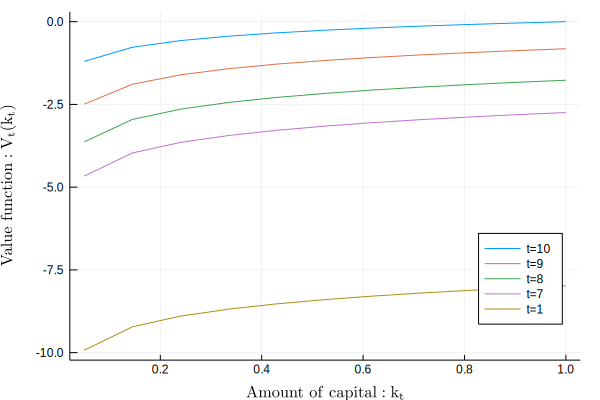

In [8]:
plot(m.kgrid, vfcn[:, end], label ="t=10", 
     legend =:bottomright)
plot!(m.kgrid, vfcn[:, 9], label ="t=9")
plot!(m.kgrid, vfcn[:, 8], label ="t=8")
plot!(m.kgrid, vfcn[:, 7], label ="t=7")
plot!(m.kgrid, vfcn[:, 1], label ="t=1")
xlabel!(L"\mathrm{Amount\ of\ capital :  k_t }")
ylabel!(L"\mathrm{Value\  function  :  V_t(k_t)} ")
#savefig("Fig3_rc1.pdf")

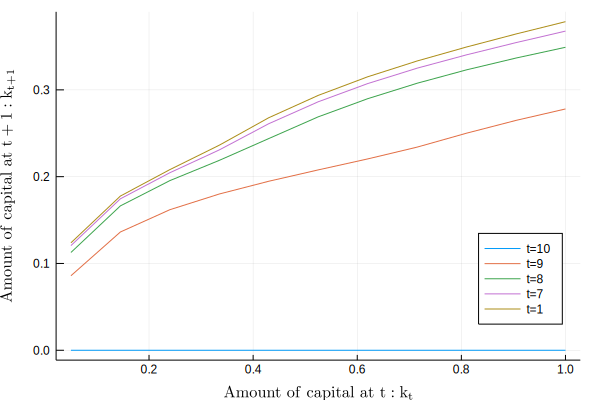

In [9]:
plot(m.kgrid, pfcn[:, end], label ="t=10", 
     legend =:bottomright)
plot!(m.kgrid, pfcn[:, 9], label ="t=9")
plot!(m.kgrid, pfcn[:, 8], label ="t=8")
plot!(m.kgrid, pfcn[:, 7], label ="t=7")
plot!(m.kgrid, pfcn[:, 1], label ="t=1")
xlabel!(L"\mathrm{Amount\ of\ capital\ at\ t :  k_t }")
ylabel!(L"\mathrm{Amount\ of\ capital\ at\ t+1 :  k_{t+1} }")
#savefig("Fig3_rc2.pdf")

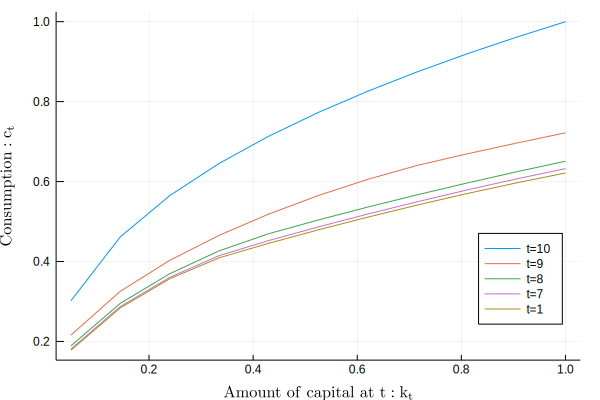

In [10]:
plot(m.kgrid, cfcn[:, end], label ="t=10", 
     legend =:bottomright)
plot!(m.kgrid, cfcn[:, 9], label ="t=9")
plot!(m.kgrid, cfcn[:, 8], label ="t=8")
plot!(m.kgrid, cfcn[:, 7], label ="t=7")
plot!(m.kgrid, cfcn[:, 1], label ="t=1")
xlabel!(L"\mathrm{Amount\ of\ capital\ at\ t :  k_t }")
ylabel!(L"\mathrm{Consumption :  c_t }")
#savefig("Fig3_rc3.pdf")

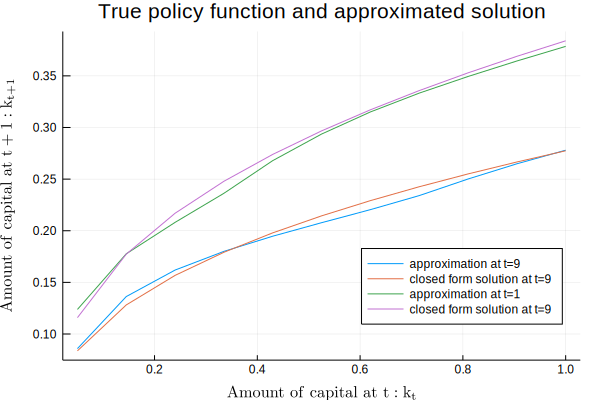

In [11]:
plot(m.kgrid, pfcn[:,9] , label="approximation at t=9",
     legend=:bottomright)
plot!(m.kgrid, p_true[:,9], label="closed form solution at t=9")
plot!(m.kgrid, pfcn[:,1], label="approximation at t=1")
plot!(m.kgrid, p_true[:,1], label="closed form solution at t=9" )
title!("True policy function and approximated solution")
xlabel!(L"\mathrm{Amount\ of\ capital\ at\ t :  k_t }")
ylabel!(L"\mathrm{Amount\ of\ capital\ at\ t+1 :  k_{t+1} }")
#savefig("Fig3_rc4.pdf")

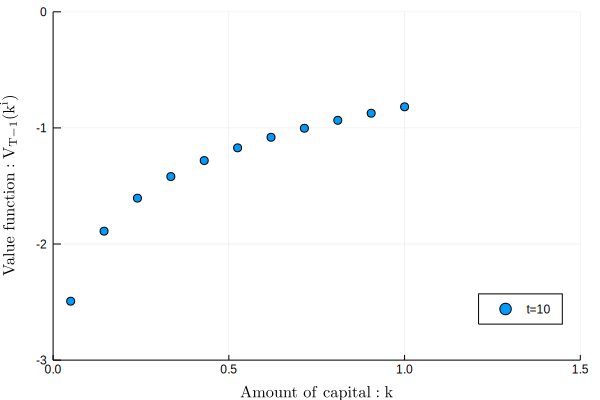

In [12]:
plot(m.kgrid, vfcn[:, end-1], label ="t=10", 
     legend =:bottomright,seriestype=:scatter)
xlabel!(L"\mathrm{Amount\ of\ capital :  k}")
ylabel!(L"\mathrm{Value\  function  :  V_{T-1}(k^i)} ")
xlims!(0, 1.5)
ylims!(-3.0, 0.0)
#savefig("Fig3_data.pdf")

In [13]:
#= 内挿補間 =#
nkk = 1001
kkmin = 0.0
kkmax = 1.5
kkgrid = collect(LinRange(kkmin, kkmax, nkk))

v_ln = zeros(nkk)
v_cs = zeros(nkk)
ln_itp = Spline1D(m.kgrid, vfcn[:,end-1], k = 1, bc = "extrapolate") #線形補間
cs_itp = Spline1D(m.kgrid, vfcn[:,end-1], k = 3, bc = "extrapolate") #スプライン補間
for i in 1:nkk
    v_ln[i] = ln_itp(kkgrid[i])
    v_cs[i] = cs_itp(kkgrid[i])
end

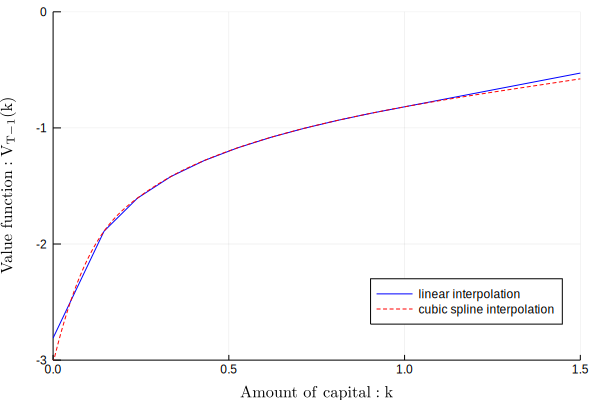

In [14]:
plot(kkgrid, v_ln, label="linear interpolation",
     color = "blue", legend=:bottomright)
plot!(kkgrid, v_cs, label="cubic spline interpolation",
      color = "red", line =:dash)
xlabel!(L"\mathrm{Amount\ of\ capital :  k}")
ylabel!(L"\mathrm{Value\  function  :  V_{T-1}(k)} ")
xlims!(0, 1.5)
ylims!(-3.0, 0.0)
#savefig("Fig3_interp.pdf")